<a href="https://colab.research.google.com/github/bimewok/Concrete-Crack-Image-Classifier/blob/main/concrete_crack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Identifying Cracks in Images of Concrete

# Introduction

One of the most promising uses of machine learning for image classification is the automation of inspection tasks using photos collected by drones. 

Maintaining infrastructure is essential to public safety and for cost-savings by catching problems early before they become expensive to repair. In the United States, there is a huge backlog of inspections of bridges, dams, levees and other large concrete structures. Reducing the cost and increasing the efficiency of inspection of such structures could save millions of dollars and potentially human lives. Drones are becoming more affordable and their controlability and photo performance is making them an attractive tool for inspection processes. Using drones to collect photos of infrastructure may save time and money in itself, but this can be compounded if the image processing could be automated with machine learning.

In this project, images of concrete labled as 'cracked' or 'not_cracked' will be classified using a convolutional neural network. 

## The Data

The dataset was first documented in the paper:<br>

L. Zhang, F. Yang, Y. Daniel Zhang and Y. J. Zhu, "Road crack detection using
deep convolutional neural network," 2016 IEEE International Conference on Image Processing (ICIP), Phoenix, AZ, 2016, pp. 3708-3712,  doi: 10.1109/ICIP.2016.7533052.

And can be downloaded at: 

https://data.mendeley.com/datasets/5y9wdsg2zt/2\

The data comes as a .rar file, which I unzipped with 7Zip. The files are arranged in a directory with a train and test folder, and within each a positive and negative folder with the corresponding images. I renamed the folders to 'crack' and 'no_crack' to be more clear. 

## Imports

In [ ]:
import numpy as np
import tensorflow as tf
import keras
import glob
import pandas as pd
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
from PIL import Image
from sklearn.calibration import calibration_curve

print('Ready to go!')

Ready to go!


## Import Images

Here we define the base directory for the photos. The photos are in:
-Concrete Crack Images for Classification
            -train
                -crack
                -no_crack
            -test
                -crack
                -no_crack
Using Keras' image dataset from directory tool, we can pull in the photos, resize them if necessary, and do any other type of preprocessing we want. The tool lets you specify the validation split for the train data, but you could also have a seperate 'val' directory as well. The last two lines let you specify the amount of persistant memory for the two datasets to speed training. 
                


In [ ]:
batch_size = 64
pix_height = 227
pix_width = 227

train_path = r'X:\datasets\concrete_crack\Concrete Crack Images for Classification\train'
test_path = r'X:\datasets\concrete_crack\Concrete Crack Images for Classification\test'

train = tf.keras.preprocessing.image_dataset_from_directory(
  train_path,
  validation_split=0.2,
  subset="training",
  seed=42,
  image_size=(pix_height, pix_width),
  batch_size=batch_size)

val = tf.keras.preprocessing.image_dataset_from_directory(
  train_path,
  validation_split=0.2,
  subset="validation",
  seed=42,
  image_size=(pix_height, pix_width),
  batch_size=batch_size)

classes = train.class_names
print('classes: ' +str(classes))

AUTOTUNE = tf.data.experimental.AUTOTUNE

train = train.cache().prefetch(buffer_size=AUTOTUNE)
val = val.cache().prefetch(buffer_size=AUTOTUNE)

Found 36000 files belonging to 2 classes.
Using 28800 files for training.
Found 36000 files belonging to 2 classes.
Using 7200 files for validation.
classes: ['crack', 'no_crack']


## Visualize some of the photos

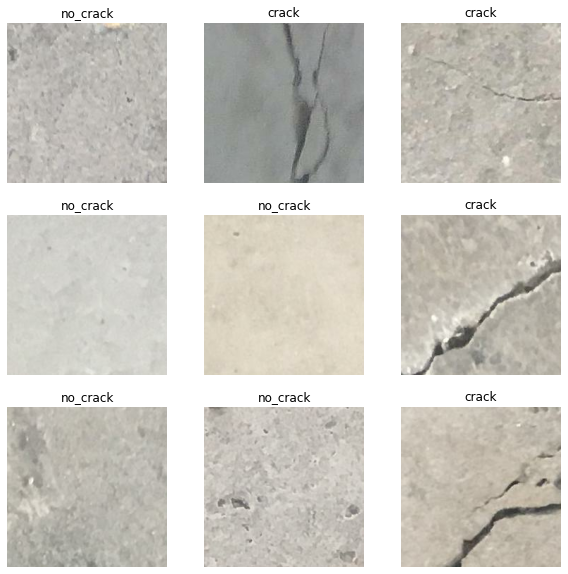

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classes[labels[i]])
    plt.axis("off")
    
plt.show()

In [ ]:
num_classes = 2

model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])
    
    
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

Epoch 1/5
450/450 [==============================] - 50s 110ms/step - loss: 0.3248 - accuracy: 0.8588 - val_loss: 0.0602 - val_accuracy: 0.9799
Epoch 2/5
450/450 [==============================] - 37s 83ms/step - loss: 0.0761 - accuracy: 0.9764 - val_loss: 0.0660 - val_accuracy: 0.9793
Epoch 3/5
450/450 [==============================] - 37s 83ms/step - loss: 0.0543 - accuracy: 0.9822 - val_loss: 0.0397 - val_accuracy: 0.9871
Epoch 4/5
450/450 [==============================] - 36s 80ms/step - loss: 0.2173 - accuracy: 0.9549 - val_loss: 0.0627 - val_accuracy: 0.9822
Epoch 5/5
450/450 [==============================] - 37s 83ms/step - loss: 0.0462 - accuracy: 0.9857 - val_loss: 0.0418 - val_accuracy: 0.9869


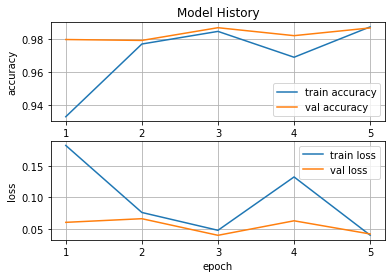

INFO:tensorflow:Assets written to: C:\garrett_workspace\PROJECTS\concrete\assets


In [ ]:
history = model.fit(
  train,
  validation_data=val,
  epochs=5
)

h = pd.DataFrame(history.history)
h['epoch'] = h.index + 1




plt.subplot(2, 1, 1)
plt.plot(h['epoch'], h['accuracy'], h['epoch'], h['val_accuracy'])
plt.title('Model History')
plt.ylabel('accuracy')
plt.grid(True)
plt.legend(('train accuracy', 'val accuracy'),
           loc='lower right')
ax1 = plt.gca()
ax1.set_xticks(range(1, max(h['epoch'])+1))


plt.subplot(2, 1, 2)
plt.plot(h['epoch'], h['loss'], h['epoch'], h['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend(('train loss', 'val loss'),
           loc='upper right')
ax2 = plt.gca()
ax2.set_xticks(range(1, max(h['epoch'])+1))

plt.show()


model.save(r'C:\garrett_workspace\PROJECTS\concrete')

loaded_model = tf.keras.models.load_model(r'C:\garrett_workspace\PROJECTS\concrete')

## Make Predictions

The following cell pulls all of the test photos, converts them to arrays, gets a prediction for them, and appends the results from each photo in a dataframe. You can use the import method from above as well, but it can be a bit difficult to get the results a useful format.  

In [ ]:
results = pd.DataFrame(columns=['predicted', 'actual', 'probability', 'file'])
test_path = r'X:\datasets\concrete_crack\Concrete Crack Images for Classification\test'
at = 0
for label in classes: 
    path = test_path+'//'+label
    for filepath in glob.iglob(path + '\\*'):
        img = keras.preprocessing.image.load_img(
        filepath, target_size=(pix_height, pix_width)
        )
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0) # Create a batch
        
        predictions = loaded_model.predict(img_array)
        score = tf.nn.softmax(predictions[0])
        results = results.append({'predicted': classes[np.argmax(score)], 'actual': label, 
                                  'probability': 100 * np.max(score), 'file': filepath}, ignore_index=True)
        at +=1
        if at % 200 == 0:
            print(str(round(((at / 4000) * 100), 1))+'%')

        

score = accuracy_score(results['actual'], results['predicted'])
print('overall test accuracy: '+str(score))

5.0%
10.0%
15.0%
20.0%
25.0%
30.0%
35.0%
40.0%
45.0%
50.0%
55.0%
60.0%
65.0%
70.0%
75.0%
80.0%
85.0%
90.0%
95.0%
100.0%
overall test accuracy: 0.99325


## Visualize Model Error

With a test accuracy of .993, there were 28 classification errors out of 4000 images. Not bad at all, although it seems like the mistakes it made should have been easy to catch:

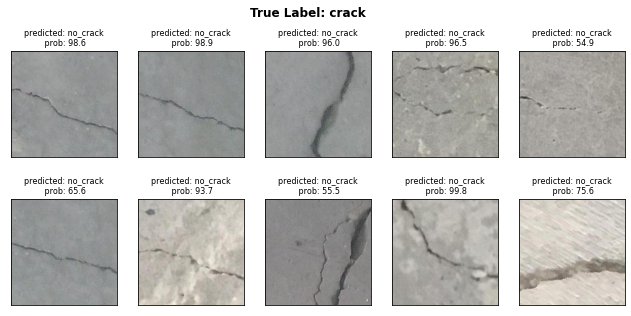

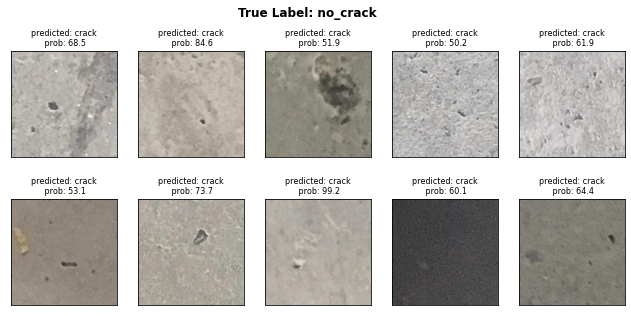

In [ ]:
for i in classes:
   mistakes = results.loc[(results['predicted'] != i) & (results['actual'] == i)]
   files = mistakes['file'].tail(10).values
   fig,ax = plt.subplots(2,int(len(files) / 2) + (int(len(files) % 2 > 0)))
   fig.set_size_inches(11, 5)
   prob = mistakes['probability'].tail(10).values
   act = mistakes['actual'].tail(10).values
   pred = mistakes['predicted'].tail(10).values
   fig.suptitle('True Label: '+str(i) + '\n' + ' ', weight='bold')
   
   for i in range(0, len(files)):
       with open(files[i],'rb') as f:
           image=Image.open(f)
           ax[i%2][i//2].imshow(image)
   ax_list = fig.axes
   for ax in range(len(files)):

      ax_list[ax].set_title('predicted: '+pred[ax]+ "\n" + ' prob: '+str(round(prob[ax], 1)), fontsize=8)
   for ax in range(len(ax_list)):
      ax_list[ax].set_xticks([])
      ax_list[ax].set_yticks([])
   
print()

In [ ]:
pd.set_option('precision', 1)
errors = results.loc[(results['predicted'] != results['actual'])]
for row in range(len(errors)):
    print(errors.iloc[row, 0:3].values)
print('False positive mean prob: '+str(np.mean(errors['probability'].loc[(results['predicted'] != 'no_crack')])))
print('False negative mean prob: '+str(np.mean(errors['probability'].loc[(results['predicted'] == 'no_crack')])))

    

['no_crack' 'crack' 96.82954549789429]
['no_crack' 'crack' 98.61034154891968]
['no_crack' 'crack' 98.93200397491455]
['no_crack' 'crack' 95.96179723739624]
['no_crack' 'crack' 96.49124145507812]
['no_crack' 'crack' 54.92211580276489]
['no_crack' 'crack' 65.55989980697632]
['no_crack' 'crack' 93.66918206214905]
['no_crack' 'crack' 55.512917041778564]
['no_crack' 'crack' 99.78184700012207]
['no_crack' 'crack' 75.57394504547119]
['crack' 'no_crack' 56.99485540390015]
['crack' 'no_crack' 79.58800196647644]
['crack' 'no_crack' 74.85791444778442]
['crack' 'no_crack' 57.65749216079712]
['crack' 'no_crack' 51.98518633842468]
['crack' 'no_crack' 67.43519902229309]
['crack' 'no_crack' 68.47202777862549]
['crack' 'no_crack' 84.56825613975525]
['crack' 'no_crack' 51.933133602142334]
['crack' 'no_crack' 50.20018219947815]
['crack' 'no_crack' 61.927640438079834]
['crack' 'no_crack' 53.095901012420654]
['crack' 'no_crack' 73.68291020393372]
['crack' 'no_crack' 99.19428825378418]
['crack' 'no_crack' 6

<ipython-input-112-e5126ca1be5c>:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax1.set_xticks([r + (barWidth / 2) for r in range(len(bars1))], ['Crack', 'No Crack'])
<ipython-input-112-e5126ca1be5c>:54: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax2.set_xticks([r + (barWidth / 2) for r in range(len(bars1))], ['Crack', 'No Crack'])


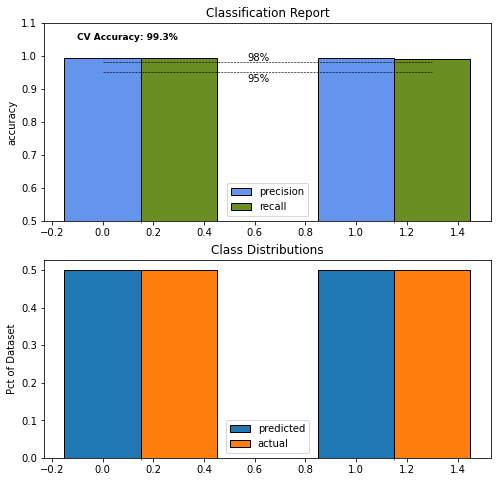

In [ ]:
report = classification_report(results['actual'], results['predicted'], output_dict=True)

plt.figure(figsize=(8,8))
plt.subplot(211)
# width of the bars
barWidth = 0.3
 
bars1 = [report['crack']['precision'], report['no_crack']['precision']]
bars2 = [report['crack']['recall'], report['no_crack']['recall']]
 
# create a numerical x axis to place labels and bars on
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = np.append(r1, r2)
plt.bar(r1, bars1, width = barWidth, color = 'cornflowerblue', edgecolor = 'black', capsize=7, label='precision')
plt.bar(r2, bars2, width = barWidth, color = 'olivedrab', edgecolor = 'black', capsize=7, label='recall')

plt.text(-.1, 1.05, r'CV Accuracy: '+str(round(report['accuracy']*100, 1))+'%', fontsize=9, fontweight='bold')
ax1 = plt.gca()
ax1.set_xticks([r + (barWidth / 2) for r in range(len(bars1))], ['Crack', 'No Crack'])
plt.ylabel('accuracy')
plt.ylim([0.5, 1.1])

label = [bars1[0], bars2[0], bars1[1], bars2[1]]
plt.title('Classification Report')
plt.legend()

plt.hlines(0.95, xmin=min(r3), xmax=max(r3), color='black', linestyles='dashed', label='95%', linewidth=0.6)
plt.hlines(0.98, xmin=min(r3), xmax=max(r3), color='black', linestyles='dashed', label='98%', linewidth=0.6)
plt.text(0.57, 0.995, '98%', ha='left', va='center')
plt.text(0.57, 0.93, '95%', ha='left', va='center')


# figure 2: class distribution from predictions and train dataset as a whole


plt.subplot(212)

predicted_dist = [(results['predicted'] == 'crack').sum() / 4000, (results['predicted'] == 'no_crack').sum() / 4000]

actual_dist = [(results['actual'] == 'crack').sum() / 4000, (results['actual'] == 'no_crack').sum() / 4000]

barWidth = 0.3
 
bars1 = predicted_dist
bars2 = actual_dist
 
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

plt.bar(r1, bars1, width = barWidth, color = 'tab:blue', edgecolor = 'black', capsize=7, label='predicted')
plt.bar(r2, bars2, width = barWidth, color = 'tab:orange', edgecolor = 'black', capsize=7, label='actual')
ax2 = plt.gca()
ax2.set_xticks([r + (barWidth / 2) for r in range(len(bars1))], ['Crack', 'No Crack'])
plt.ylabel('Pct of Dataset')
plt.legend()
plt.title('Class Distributions')


plt.show()


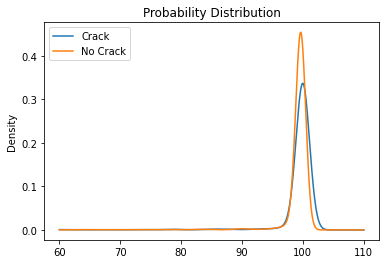

In [ ]:
crack = results.loc[(results['predicted'] == 'crack')]
no_crack = results.loc[(results['predicted'] == 'no_crack')]
probs = pd.DataFrame({'Crack': crack['probability'], 'No Crack': no_crack['probability']})

ax = probs.plot.kde(ind=[i for i in np.linspace(start = 60, stop = 110, num = 1000)], 
                    title='Probability Distribution', xlabel='Probability')

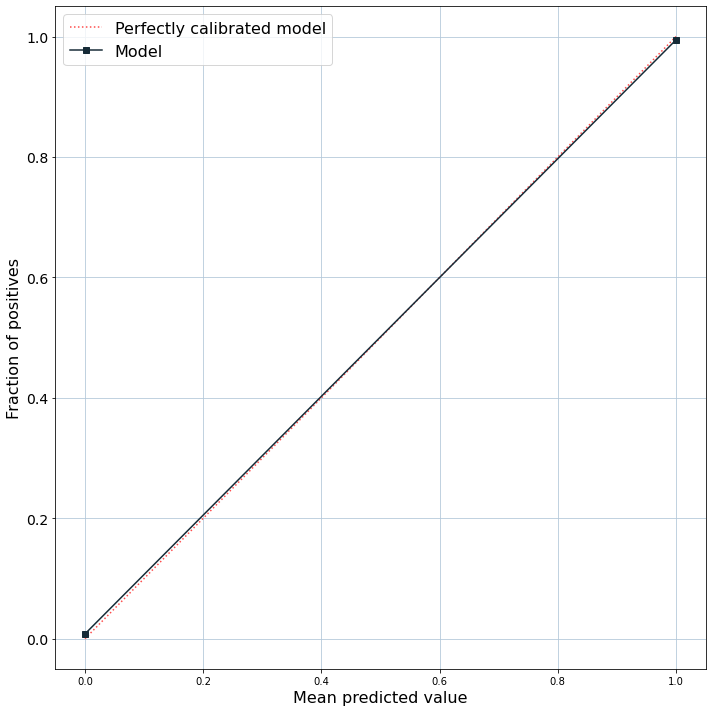

In [ ]:
prob_true_binary, prob_pred_binary = calibration_curve(results['actual'].map({'crack': 0, 'no_crack': 1}), 
                                                       results['predicted'].map({'crack': 0, 'no_crack': 1}), n_bins=10)

def plot_reliability_diagram(prob_true, prob_pred, model_name, ax=None):
    # Plot the calibration curve for ResNet in comparison with what a perfectly calibrated model would look like
    if ax==None:
        fig = plt.figure(figsize=(10, 10))
        ax = plt.gca()
    else:
        plt.sca(ax)
    
    plt.plot([0, 1], [0, 1], color="#FE4A49", linestyle=":", label="Perfectly calibrated model")
    plt.plot(prob_pred, prob_true, "s-", label=model_name, color="#162B37")

    plt.ylabel("Fraction of positives", fontsize=16)
    plt.xlabel("Mean predicted value", fontsize=16,)

    plt.legend(fontsize=16)
    
    
    plt.yticks(fontsize=14)

    plt.grid(True, color="#B2C7D9")

    plt.tight_layout()

plot_reliability_diagram(prob_true_binary, prob_pred_binary, "Model")

# Conclusion

The model is not resulting in class bias in its predictions, and precision and recall are about as equal as they could be. The resulting model is functioning well. However, in this use case, the impact of a false negative is worse than that of a false positive. Thus, it may be worth it to sacrifice overall accuracy a bit and test out some loss functions or class weights that might help alleviate this. You could also increase the probability threshold for classifying an image as not cracked. 